In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### 7.8 Lab : Non-linear Modeling
In this lab, we re-analyze the Wage data considered in the examples throughout this chapter, in order to illustrate the fact that many of the complex
non-linear fitting procedures discussed can be easily implemented in Python.

We load the data:

In [2]:
df = pd.read_csv('Data/Wage.csv')
display(df.head(3))


,Unnamed: 0,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,231655,2006,18,1. Male,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,86582,2004,24,1. Male,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,161300,2003,45,1. Male,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177


We will be using SkLearn for the polynomial regression. SkLearn doesn't have inbuilt standard error estimation. This can be computed using linear algeabre, which I won't attempt now.

In [3]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

# Fit a degree 4 polynomial regression 
model = Pipeline([('poly', PolynomialFeatures(degree=4)),
                  ('linear', LinearRegression())])
X = df.age.values.reshape(-1,1)
Y = df.wage.values.reshape(-1,1)
model.fit(X, Y)



Pipeline(steps=[('poly', PolynomialFeatures(degree=4)),
                ('linear', LinearRegression())])

We now create a grid of values for age at which we want predictions, and
then call the generic predict() function.

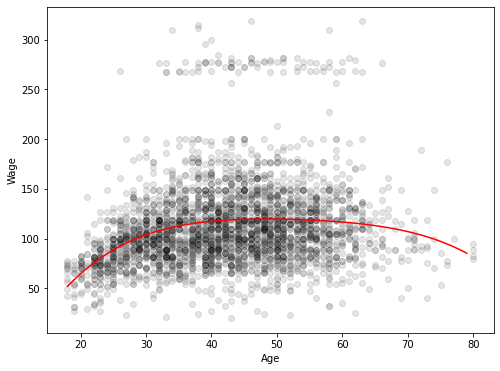

In [4]:
# Generate a sequence of ages
age_grid = np.arange(X.min(), X.max()).reshape(-1,1)

# Predict the wages
preds = model.predict(age_grid)

# Plot
fig, ax = plt.subplots(figsize=(8,6))
plt.scatter(X, Y, alpha=0.1, color = 'k')
plt.plot(age_grid, preds, color = 'r', alpha = 1)
plt.xlabel('Age')
plt.ylabel('Wage')
plt.show()

In performing a polynomial regression we must decide on the degree of
the polynomial to use. One way to do this is by using hypothesis tests.  

We
now fit models ranging from linear to a degree-5 polynomial and seek to
determine the simplest model which is sufficient to explain the relationship between wage and age. 

We use the anova_lm() function from StatsModels, which performs an  analysis of variance (ANOVA, using an F-test) in order to test the null analysis of
hypothesis that a model M1 is sufficient to explain the data against the variance
alternative hypothesis that a more complex model M2 is required.  In this case,
we fit five different models using StatsModels and sequentially compare the simpler model to
the more complex mode.

In [5]:
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm


X1 = PolynomialFeatures(degree=1).fit_transform(X)
X2 = PolynomialFeatures(degree=2).fit_transform(X)
X3 = PolynomialFeatures(degree=3).fit_transform(X)
X4 = PolynomialFeatures(degree=4).fit_transform(X)
X5 = PolynomialFeatures(degree=5).fit_transform(X)

model1 = sm.OLS(df['wage'], X1).fit()
model2 = sm.OLS(df['wage'], X2).fit()
model3 = sm.OLS(df['wage'], X3).fit()
model4 = sm.OLS(df['wage'], X4).fit()
model5 = sm.OLS(df['wage'], X5).fit()

display(anova_lm(model1,model2,model3,model4,model5))

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,5.022216e+06,0.0,NaN,NaN,NaN
1,2997.0,4.793430e+06,1.0,228786.010128,143.593107,2.363850e-32
2,2996.0,4.777674e+06,1.0,15755.693664,9.888756,1.679202e-03
3,2995.0,4.771604e+06,1.0,6070.152124,3.809813,5.104620e-02
4,2994.0,4.770322e+06,1.0,1282.563017,0.804976,3.696820e-01


The p-value comparing the linear Model 1 to the quadratic Model 2 is
essentially zero (<10−31), indicating that a linear fit is not sufficient. Similarly the p-value comparing the quadratic Model 2 to the cubic Model 3
is very low (0.0017), so the quadratic fit is also insufficient. The p-value
comparing the cubic and degree-4 polynomials, Model 3 and Model 4, is approximately 5 % while the degree-5 polynomial Model 5 seems unnecessary
because its p-value is 0.37. Hence, either a cubic or a quartic polynomial
appear to provide a reasonable fit to the data, but lower- or higher-order
models are not justified.


In this case, instead of using the anova() function, we could have obtained
these p-values more succinctly by exploiting
orthogonal polynomials. I will not do this here as sklearn can't do it and I would have to implement QR decomposition. We would see that the p-values are the same, and in fact the square of the
t-statistics are equal to the F-statistics from the anova() function.

However, the ANOVA method works whether or not we used orthogonal
polynomials; it also works when we have other terms in the model as well.

As an alternative to using hypothesis tests and ANOVA, we could choose
the polynomial degree using cross-validation, as discussed in Chapter 5.

Next we consider the task of predicting whether an individual earns more
than $250,000 per year. We proceed much as before, except that first we
create the appropriate response vector, and then fit a polynomial logistic regression
model.

Optimization terminated successfully.
         Current function value: 0.116870
         Iterations 12


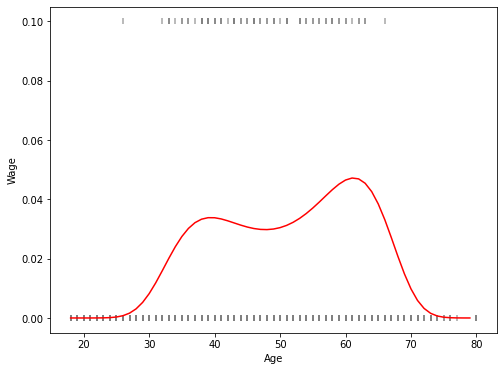

In [86]:
from sklearn.linear_model import LogisticRegression

# X and Y
X = df.age.values.reshape(-1,1)
X_poly = PolynomialFeatures(degree=4).fit_transform(X)
y_bool = np.array(df.wage.values > 250, dtype = "int")

# Generate a sequence of ages
age_grid = np.arange(X.min(), X.max()).reshape(-1,1)
age_grid_poly =  PolynomialFeatures(degree=4).fit_transform(age_grid)

# Model
log_reg = sm.Logit(y_bool, X_poly).fit()
preds = log_reg.predict(age_grid_poly)
# Plot
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(X ,y_bool/10, s=30, c='grey', marker='|', alpha=0.7)
plt.plot(age_grid, preds, color = 'r', alpha = 1)
plt.xlabel('Age')
plt.ylabel('Wage')
plt.show()


We have drawn the age values corresponding to the observations with wage
values above 250 as gray marks on the top of the plot, and those with wage
values below 250 are shown as gray marks on the bottom of the plot. This is often called a
rug plot.

In order to fit a step function, as discussed in Section 7.2, we use the
cut() function.

In [120]:
# Cut predictor data and into intervals of a step function
wage_cut, bins = pd.cut(df.age, 4, retbins=True, right=True)
display(wage_cut.value_counts(sort=False))

# Create dummies for predictor intervals
# The first interval is the base and dropped
wage_step_dummies = pd.DataFrame(sm.add_constant(pd.get_dummies(wage_cut, drop_first=True)))  
display(wage_step_dummies.head(5))



# Piecewise-constant regression as a step function
model = sm.OLS(df.wage, wage_step_dummies ).fit()
display(model.summary())


(17.938, 33.5]     750
(33.5, 49.0]      1399
(49.0, 64.5]       779
(64.5, 80.0]        72
Name: age, dtype: int64

,const,"(33.5, 49.0]","(49.0, 64.5]","(64.5, 80.0]"
0,1.0,0,0,0
1,1.0,0,0,0
2,1.0,1,0,0
3,1.0,1,0,0
4,1.0,0,1,0


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     66.58
Date:                Sat, 27 Mar 2021   Prob (F-statistic):           1.13e-41
Time:                        17:40:12   Log-Likelihood:                -15353.
No. Observations:                3000   AIC:                         3.071e+04
Df Residuals:                    2996   BIC:                         3.074e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           94.1584      1.476     63.790      0.000      91.264      97.053
(33.5, 49.0]    24.0535      1.829     13.148      0.000      20.466      27.641
(49.0, 64.5]    23.6646      2.068     11.443      0.000      19.610      27.719
(64.5, 80.0]     7.6406      4.987      1.532      0.126      -2.139      17.420
==============================================================================
Omnibus:                     1062.354   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4551.200
Skew:                           1.681   Prob(JB):                         0.00
Kurtosis:                       8.011   Cond. No.                         7.88
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Here cut() automatically picked the cutpoints at 33.5, 49, and 64.5 years
of age. We could also have specified our own cutpoints directly using the
bins option. The function cut() returns an ordered categorical variable. The age<33.5 category is left out, so the intercept coefficient of
$94,160 can be interpreted as the average salary for those under 33.5 years
of age, and the other coefficients can be interpreted as the average additional salary for those in the other age groups. We can produce predictions
and plots just as we did in the case of the polynomial fit.

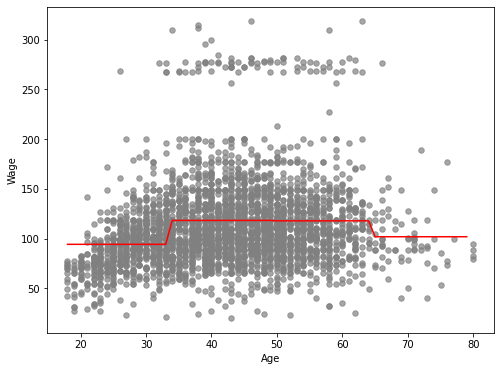

In [118]:
# Making age-grid into the same shape to predict
# The first interval is the base and dropped
# The bins are chosen as before
age_grid = np.arange(X.min(), X.max())
age_cut, bins = pd.cut(age_grid.ravel(), bins = bins, retbins=True, right=True)
age_step_dummies = pd.DataFrame(sm.add_constant(pd.get_dummies(age_cut, drop_first=True))) 
preds = logreg_step.predict(age_step_dummies)
# Plot
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(X ,df.wage, s=30, c='grey', alpha=0.7)
plt.plot(age_grid, preds, color = 'r', alpha = 1)
plt.xlabel('Age')
plt.ylabel('Wage')
plt.show()

### 7.8.2 Splines

We will continue using the StatsModels library for this section. The package `patsy` will be used to generate the spline basis. The spline bases returned by bs() are designed to be compatible with those produced by the R bs function.
The bs() function generates the entire matrix of bs() basis functions for splines with the specified set of knots. Cubic
splines are produced. Fitting wage to age using a regression spline is simple:


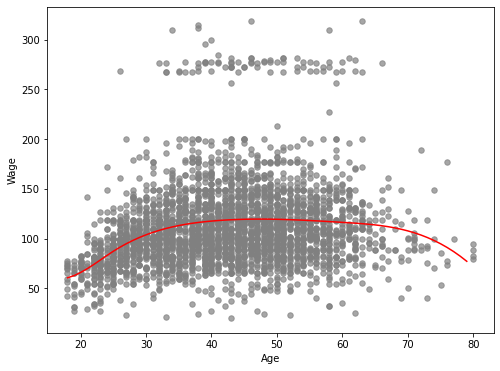

In [129]:
from patsy import dmatrix

spline_X = dmatrix("bs(df.age, knots=(25,40,60), degree=3, include_intercept=False)",
                        {"df.age": df.age}, return_type='dataframe')

fitted_model = sm.OLS(df.wage, spline_X).fit()

age_grid_spline = dmatrix("bs(age_grid, knots=(25,40,60), degree=3, include_intercept=False)",
                        {"age_grid": age_grid}, return_type='dataframe')
pred = fitted_model.predict(age_grid_spline)

# Plot
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(X ,df.wage, s=30, c='grey', alpha=0.7)
plt.plot(age_grid, pred, color = 'r', alpha = 1)
plt.xlabel('Age')
plt.ylabel('Wage')
plt.show()

Here we have prespecified knots at ages 25, 40, and 60. This produces a
spline with six basis functions. (Recall that a cubic spline with three knots
has seven degrees of freedom; these degrees of freedom are used up by an
intercept, plus six basis functions.) We could also use the df option to
produce a spline with knots at uniform quantiles of the data.

In [132]:
display(spline_X.head(5))
display(spline_X.shape)

,Intercept,"bs(df.age, knots=(25, 40, 60), degree=3, include_intercept=False)[0]","bs(df.age, knots=(25, 40, 60), degree=3, include_intercept=False)[1]","bs(df.age, knots=(25, 40, 60), degree=3, include_intercept=False)[2]","bs(df.age, knots=(25, 40, 60), degree=3, include_intercept=False)[3]","bs(df.age, knots=(25, 40, 60), degree=3, include_intercept=False)[4]","bs(df.age, knots=(25, 40, 60), degree=3, include_intercept=False)[5]"
0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,1.0,0.559911,0.403778,0.033395,0.000000,0.000000,0.0
2,1.0,0.000000,0.114796,0.618564,0.262733,0.003906,0.0
3,1.0,0.000000,0.167109,0.633167,0.198880,0.000844,0.0
4,1.0,0.000000,0.034014,0.508194,0.426542,0.031250,0.0


(3000, 7)

In [ ]:
THere we have prespecified knots at ages 25, 40, and 60. This produces a
spline with six basis functions. (Recall that a cubic spline with three knots
has seven degrees of freedom; these degrees of freedom are used up by an
intercept, plus six basis functions.) We could also use the df option to
produce a spline with knots at uniform quantiles of the data. 

In order to instead fit a natural spline, we use the cr() function. Here cr() we fit a natural spline with four degrees of freedom

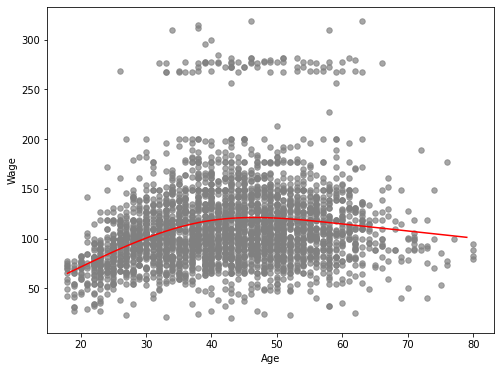

In [140]:
spline_X = dmatrix("cr(df.age, df=4)",
                        {"df.age": df.age}, return_type='dataframe')
fitted_model = sm.OLS(df.wage, spline_X).fit()

age_grid_spline = dmatrix("cr(age_grid,df=4)",
                        {"age_grid": age_grid}, return_type='dataframe')
pred = fitted_model.predict(age_grid_spline)

# Plot
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(X ,df.wage, s=30, c='grey', alpha=0.7)
plt.plot(age_grid, pred, color = 'r', alpha = 1)
plt.xlabel('Age')
plt.ylabel('Wage')
plt.show()

### GAMs
I am skipping this section, because the examples are really R-pecific and it would be a pain to reimplement everything/ ask StatsModels on GitHub how exactly some of their library works. I don't think this is worth the time, I'd rather just do it in R if I wanted to do these specific things.